In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from dataclasses import dataclass
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

2023-12-02 08:16:32.129894: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-02 08:16:32.175249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
@dataclass
class Params:
    input_dim: tuple = (23,1)  # Input dimension based on features
    output_dim: int = 1  # Output dimension (binary classification)
    dropout: float = 0.3  # Dropout rate for regularization
    learning_rate: float = 0.001  # Learning rate for optimizer
    epochs: int = 50  # Number of training epochs
    batch_size: int = 32  # Batch size for training
    save_dir: str = Path('checkpoints')  # Directory to save model checkpoints
    save_path: str = save_dir/'model.keras'  # Path to save the model
    verbose: int = 0  # Verbosity mode

    # Create directory if it doesn't exist
    save_dir.mkdir(parents=True, exist_ok=True)

# Create an instance of Params
params = Params()

In [3]:
df = pd.read_csv('weatherHistory.csv', index_col=0)

def prep_data(df):
    temp = df[['Temperature (C)']]
    temp_array = temp.values[:96432]
    temp_array = temp_array.reshape(-1,24)
    data = pd.DataFrame(temp_array, columns=np.arange(1,25))
    remains = temp.values[96432:]
    X = data.iloc[:,:-1]
    y = data.iloc[:,-1]

    # Split the data into train and temporary sets
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

    # Split the temporary set into validation and test sets
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, shuffle=False)

    # Print the shapes of the splits
    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"y_val shape: {y_val.shape}")
    print(f"y_test shape: {y_test.shape}")

    return X_train, X_val, X_test, y_train, y_val, y_test, remains

X_train, X_val, X_test, y_train, y_val, y_test, remains = prep_data(df)

X_train shape: (2813, 23)
X_val shape: (602, 23)
X_test shape: (603, 23)
y_train shape: (2813,)
y_val shape: (602,)
y_test shape: (603,)


In [4]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, remains.shape

((2813, 23), (603, 23), (2813,), (603,), (21, 1))

In [5]:
optimizer = keras.optimizers.Adam(learning_rate=params.learning_rate)
loss = keras.losses.MeanSquaredError()
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=params.verbose, min_lr=1e-8, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(params.save_path, monitor='val_loss', save_best_only=True, mode='min', verbose=params.verbose)
callbacks = [early_stopping, reduce_lr, model_checkpoint]

In [6]:
# Define the model
model:keras.Model = keras.models.Sequential([
    keras.Input(shape=(23,1)),
    keras.layers.SimpleRNN(50, activation='tanh'),
    keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=optimizer, loss=loss)
# Train the model
hist = model.fit(X_train, y_train, epochs=params.epochs, batch_size=params.batch_size, validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 110.5719 - val_loss: 24.7913 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 33.3434 - val_loss: 11.8400 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 19.4711 - val_loss: 6.2588 - learning_rate: 0.0010
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 12.9614 - val_loss: 3.3210 - learning_rate: 0.0010
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 9.1654 - val_loss: 2.1362 - learning_rate: 0.0010
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 6.7653 - val_loss: 1.5140 - learning_rate: 0.0010
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.5246 - val_loss: 1.2922 - learning_rate: 0.0010
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.1484 - val_loss: 1.1003 - learning_rate: 0.0010
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 5.0734 - val_loss: 1.0284 - learning_rate: 0.0010
Epoch 10/50


In [7]:
model.history.history.keys()

dict_keys(['loss', 'val_loss', 'learning_rate'])

In [8]:
# model(remains.ravel())

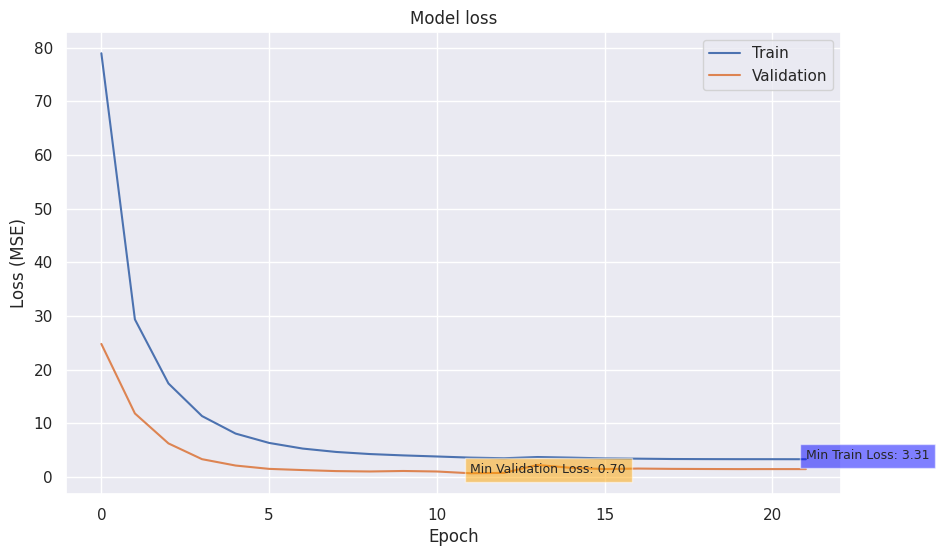

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of Seaborn
sns.set()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Validation')

# Find the minimum loss values and their corresponding epochs
min_train_loss = min(hist.history['loss'])
min_val_loss = min(hist.history['val_loss'])
min_train_loss_epoch = hist.history['loss'].index(min_train_loss)
min_val_loss_epoch = hist.history['val_loss'].index(min_val_loss)

# Add text for the minimum loss values
plt.text(min_train_loss_epoch, min_train_loss, f'Min Train Loss: {min_train_loss:.2f}', fontsize=9, 
         bbox=dict(facecolor='blue', alpha=0.5))
plt.text(min_val_loss_epoch, min_val_loss, f'Min Validation Loss: {min_val_loss:.2f}', fontsize=9, 
         bbox=dict(facecolor='orange', alpha=0.5))

# Add title and labels
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')

# Add legend
plt.legend()

# Show the plot
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


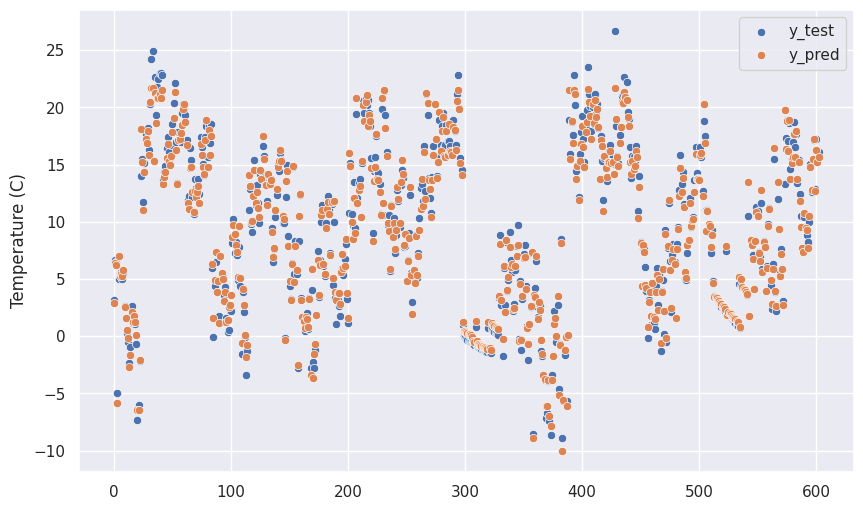

In [10]:
#plot scatter plot of y_test using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(y_test)), y=y_test)
sns.scatterplot(x=np.arange(len(y_test)), y=model.predict(X_test).ravel())
plt.legend(['y_test', 'y_pred'])
plt.ylabel('Temperature (C)')
plt.show()

In [11]:
model.state_dict()

OrderedDict([('_functional.torch_params.0',
              tensor([[-0.2685, -0.2679,  0.3090,  0.0391,  0.0013,  0.2534, -0.1728,  0.2342,
                       -0.0244,  0.2049,  0.0101, -0.1910, -0.1141, -0.2375, -0.0589, -0.2350,
                        0.0563, -0.1143,  0.0163, -0.1617, -0.1993,  0.3464, -0.0215,  0.1228,
                        0.0142, -0.2395,  0.0091, -0.0795, -0.2067,  0.0815, -0.2184, -0.2396,
                       -0.2190,  0.0681,  0.0188, -0.0784, -0.2779,  0.2485,  0.2790,  0.2348,
                        0.0257,  0.1942,  0.0324,  0.0525,  0.1270,  0.1617,  0.0471,  0.2745,
                       -0.1903, -0.1334]])),
             ('_functional.torch_params.1',
              tensor([[-0.4685, -0.1509, -0.0300,  ...,  0.0571, -0.0241, -0.0606],
                      [-0.1972,  0.0514,  0.2458,  ..., -0.1165,  0.0792, -0.0747],
                      [ 0.2352,  0.0818, -0.1175,  ..., -0.0308, -0.2415, -0.0415],
                      ...,
                  

In [17]:
model.__class__

keras.src.models.sequential.Sequential